In [ ]:
# images 폴더에 다운로드 받은 파일 압축 해제하기
# !unzip calories.zip

# 라이브러리, 데이터 로드

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

%matplotlib inline

In [ ]:
base_path = "open"
train = pd.read_csv(f'{base_path}/train.csv', index_col="ID")
test = pd.read_csv(f'{base_path}/test.csv', index_col="ID")
sub = pd.read_csv(f'{base_path}/sample_submission.csv', index_col="ID")

In [ ]:
# categorical_feature = train.select_dtypes(include="object").columns
# train[categorical_feature] = train[categorical_feature].astype("category")
# test[categorical_feature] = test[categorical_feature].astype("category")

# 데이터 살펴보기

- 산책 < 조깅 < 웨이트.. 칼로리 소모량 차이
- 어떤 운동을 하는지 어떻게 알지?
- 심박수, 체온에 따라서 운동을 구별할 수 있다.
    - 운동과 심박수/체온은 간접적 관계가 있지 않을까?
    - 운동의 강도에 대한 간접적 측정 가능 

In [ ]:
train.head()

,Exercise_Duration,Body_Temperature(F),BPM,Height(Feet),Height(Remainder_Inches),Weight(lb),Weight_Status,Gender,Age,Calories_Burned
ID,,,,,,,,,,
TRAIN_0000,26.0,105.6,107.0,5.0,9.0,154.3,Normal Weight,F,45,166.0
TRAIN_0001,7.0,103.3,88.0,6.0,6.0,224.9,Overweight,M,50,33.0
TRAIN_0002,7.0,103.3,86.0,6.0,3.0,218.3,Overweight,M,29,23.0
TRAIN_0003,17.0,104.0,99.0,5.0,6.0,147.7,Normal Weight,F,33,91.0
TRAIN_0004,9.0,102.7,88.0,5.0,10.0,169.8,Normal Weight,M,38,32.0


In [ ]:
train.shape

(7500, 10)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7500 entries, TRAIN_0000 to TRAIN_7499
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Exercise_Duration         7500 non-null   float64
 1   Body_Temperature(F)       7500 non-null   float64
 2   BPM                       7500 non-null   float64
 3   Height(Feet)              7500 non-null   float64
 4   Height(Remainder_Inches)  7500 non-null   float64
 5   Weight(lb)                7500 non-null   float64
 6   Weight_Status             7500 non-null   object 
 7   Gender                    7500 non-null   object 
 8   Age                       7500 non-null   int64  
 9   Calories_Burned           7500 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 644.5+ KB


In [ ]:
# 결측치 확인
train.isnull().sum()

Exercise_Duration           0
Body_Temperature(F)         0
BPM                         0
Height(Feet)                0
Height(Remainder_Inches)    0
Weight(lb)                  0
Weight_Status               0
Gender                      0
Age                         0
Calories_Burned             0
dtype: int64

In [ ]:
# 중복값 확인
train[train.duplicated(keep=False)]

,Exercise_Duration,Body_Temperature(F),BPM,Height(Feet),Height(Remainder_Inches),Weight(lb),Weight_Status,Gender,Age,Calories_Burned
ID,,,,,,,,,,
TRAIN_4251,9.0,103.1,90.0,5.0,5.0,130.1,Normal Weight,F,28,40.0
TRAIN_4662,9.0,103.1,90.0,5.0,5.0,130.1,Normal Weight,F,28,40.0


## 데이터 전처리

### Train

In [ ]:
# 중복값 제거
train_new = train.drop_duplicates()

In [ ]:
train_new[train_new.duplicated(keep=False)]

,Exercise_Duration,Body_Temperature(F),BPM,Height(Feet),Height(Remainder_Inches),Weight(lb),Weight_Status,Gender,Age,Calories_Burned
ID,,,,,,,,,,


In [ ]:
train_new.columns

Index(['Exercise_Duration', 'Body_Temperature(F)', 'BPM', 'Height(Feet)',
       'Height(Remainder_Inches)', 'Weight(lb)', 'Weight_Status', 'Gender',
       'Age', 'Calories_Burned'],
      dtype='object')

In [ ]:
# Height 정제 : 1 Feet = 12 inches
train_new['Height'] = (train_new['Height(Feet)']*12) + train_new['Height(Remainder_Inches)']

<ipython-input-13-ad4b6e583827>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new['Height'] = (train_new['Height(Feet)']*12) + train_new['Height(Remainder_Inches)']


In [ ]:
train_new['Height'].head()

ID
TRAIN_0000    69.0
TRAIN_0001    78.0
TRAIN_0002    75.0
TRAIN_0003    66.0
TRAIN_0004    70.0
Name: Height, dtype: float64

In [ ]:
# 키는 합친 컬럼만 남기기
train_new = train_new.drop(columns=['Height(Feet)', 'Height(Remainder_Inches)'])

### Test

In [ ]:
X_test = test

In [ ]:
X_test.shape

(7500, 9)

In [ ]:
X_test.isnull().sum()

Exercise_Duration           0
Body_Temperature(F)         0
BPM                         0
Height(Feet)                0
Height(Remainder_Inches)    0
Weight(lb)                  0
Weight_Status               0
Gender                      0
Age                         0
dtype: int64

In [ ]:
X_test.duplicated().sum()

0

In [ ]:
X_test['Height'] = (X_test['Height(Feet)']*12) + X_test['Height(Remainder_Inches)']

In [ ]:
X_test['Height'].head()

ID
TEST_0000    61.0
TEST_0001    74.0
TEST_0002    69.0
TEST_0003    72.0
TEST_0004    67.0
Name: Height, dtype: float64

In [ ]:
# 키는 합친 컬럼만 남기기
X_test = X_test.drop(columns=['Height(Feet)', 'Height(Remainder_Inches)'])

# EDA

In [ ]:
# 통계치 확인
train_new.describe()

,Exercise_Duration,Body_Temperature(F),BPM,Weight(lb),Age,Calories_Burned,Height
count,7499.000000,7499.000000,7499.000000,7499.000000,7499.000000,7499.000000,7499.000000
mean,15.502067,104.033698,95.498867,165.365889,42.637952,89.380051,68.703694
std,8.355520,1.412898,9.587760,33.307867,16.883468,62.818686,5.637365
min,1.000000,98.800000,69.000000,79.400000,20.000000,1.000000,48.000000
25%,8.000000,103.300000,88.000000,138.900000,28.000000,35.000000,65.000000
50%,15.000000,104.400000,95.000000,163.100000,39.000000,77.000000,69.000000
75%,23.000000,105.100000,103.000000,191.800000,56.000000,138.000000,73.000000
max,30.000000,106.700000,128.000000,291.000000,79.000000,300.000000,86.000000


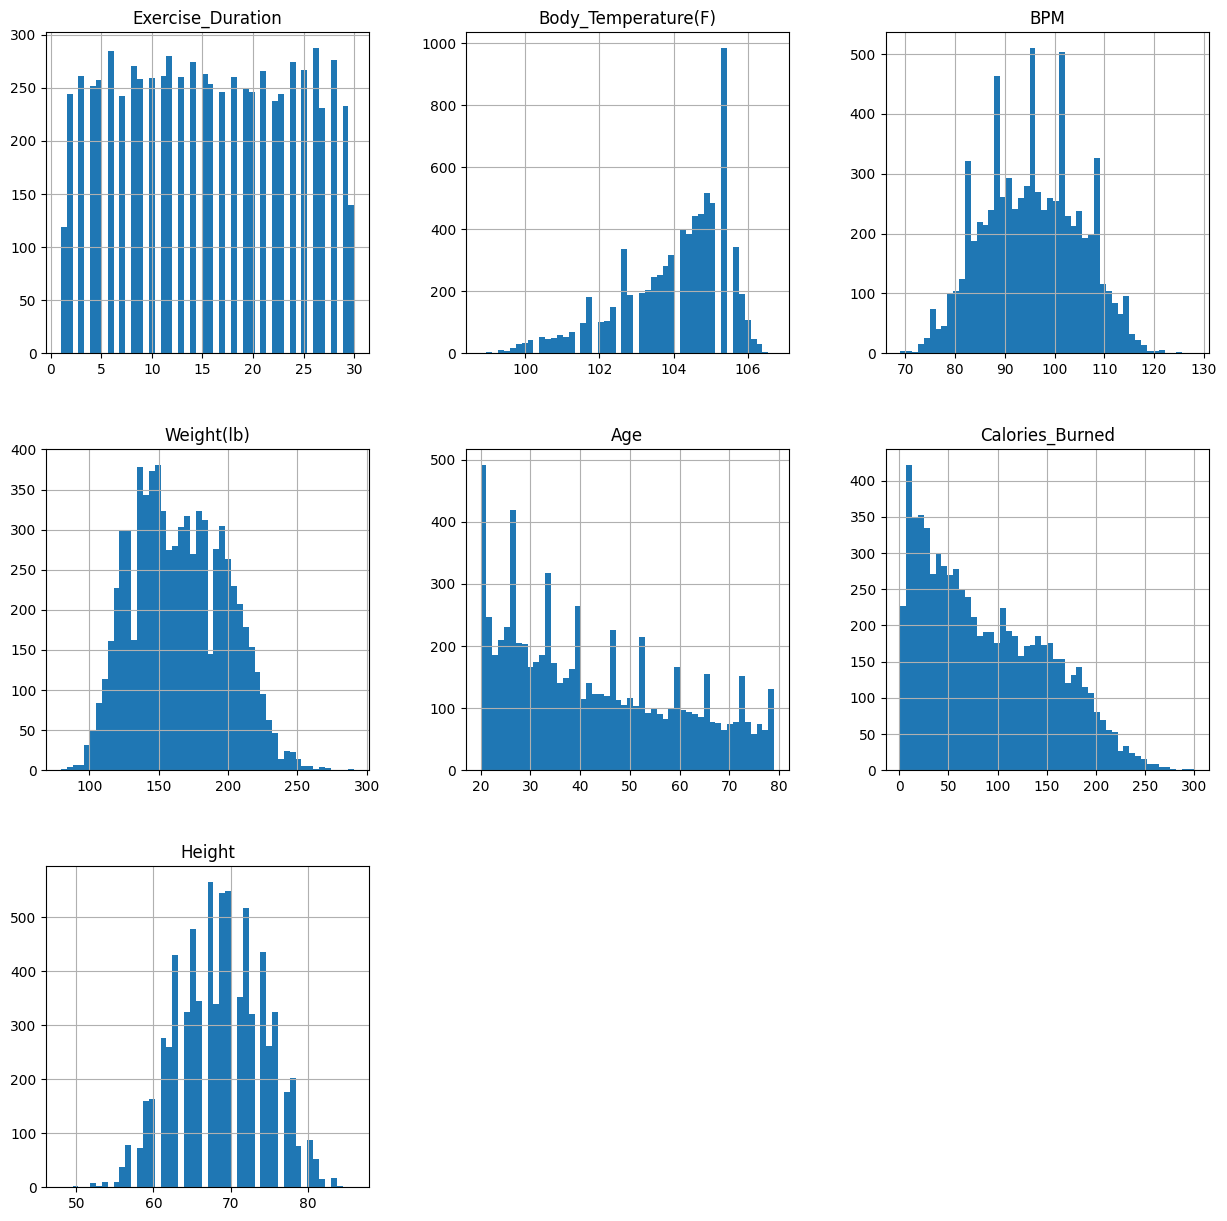

In [ ]:
train_new.hist(bins=50, figsize=(15, 15));

* 키, 무게, BPM은 정규분포를 띄고 있다.

In [ ]:
sns.set()

## 범주형 데이터 확인

In [ ]:
train['Weight_Status'].value_counts(1)

Normal Weight    0.624133
Overweight       0.348533
Obese            0.027333
Name: Weight_Status, dtype: float64

<Axes: xlabel='Weight_Status', ylabel='count'>

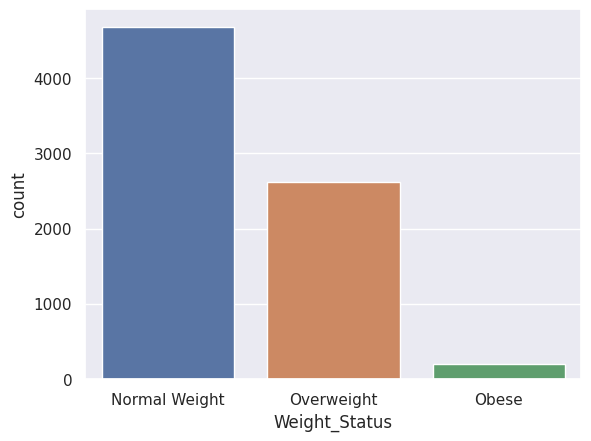

In [ ]:
# weight status 체크
sns.countplot(data = train_new, x='Weight_Status')
# train['Weight_Status'].value_counts().plot.bar(rot=0, figsize=(5,7));

<Axes: xlabel='Gender', ylabel='count'>

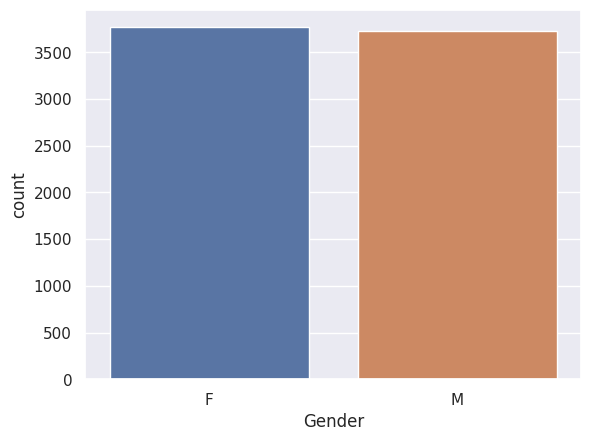

In [ ]:
# 성별 컬럼 살펴보기 : 남녀 몇명씩 있나?
sns.countplot(data = train_new, x='Gender')

* 거의 비슷하게 있다.
* 균형잡힌 분산이다.

<ipython-input-29-37c812b5e191>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_new['Age']);


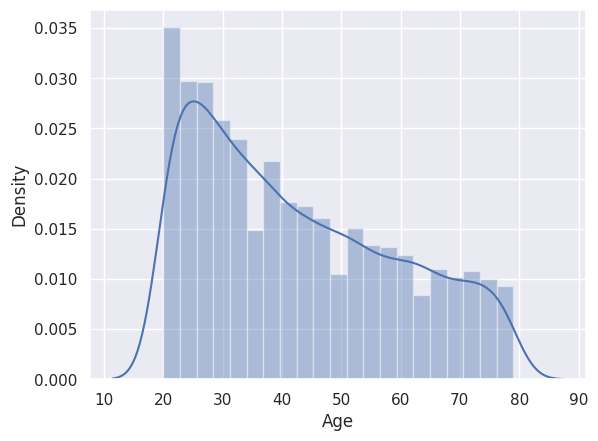

In [ ]:
# 나이 분포 살펴보기
sns.distplot(train_new['Age']);

* 2-30대가 가장 많다.
* 그 뒤에는 약간 감소함.
* 나이가 들수록 운동 안한다?

In [ ]:
# 상관관계 살펴보기
corr_df = train_new.corr()
# corr_df = corr_df.apply(lambda x: round(x ,2))
corr_df

<ipython-input-30-2b7798171b82>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = train_new.corr()


,Exercise_Duration,Body_Temperature(F),BPM,Weight(lb),Age,Calories_Burned,Height
Exercise_Duration,1.000000,0.904308,0.853483,0.002126,0.017645,0.954780,-0.003215
Body_Temperature(F),0.904308,1.000000,0.770696,0.007461,0.016399,0.824368,0.002921
BPM,0.853483,0.770696,1.000000,0.012482,0.014637,0.899896,0.006269
Weight(lb),0.002126,0.007461,0.012482,1.000000,0.090425,0.042462,0.957822
Age,0.017645,0.016399,0.014637,0.090425,1.000000,0.159548,0.011108
Calories_Burned,0.954780,0.824368,0.899896,0.042462,0.159548,1.000000,0.021839
Height,-0.003215,0.002921,0.006269,0.957822,0.011108,0.021839,1.000000


<Axes: >

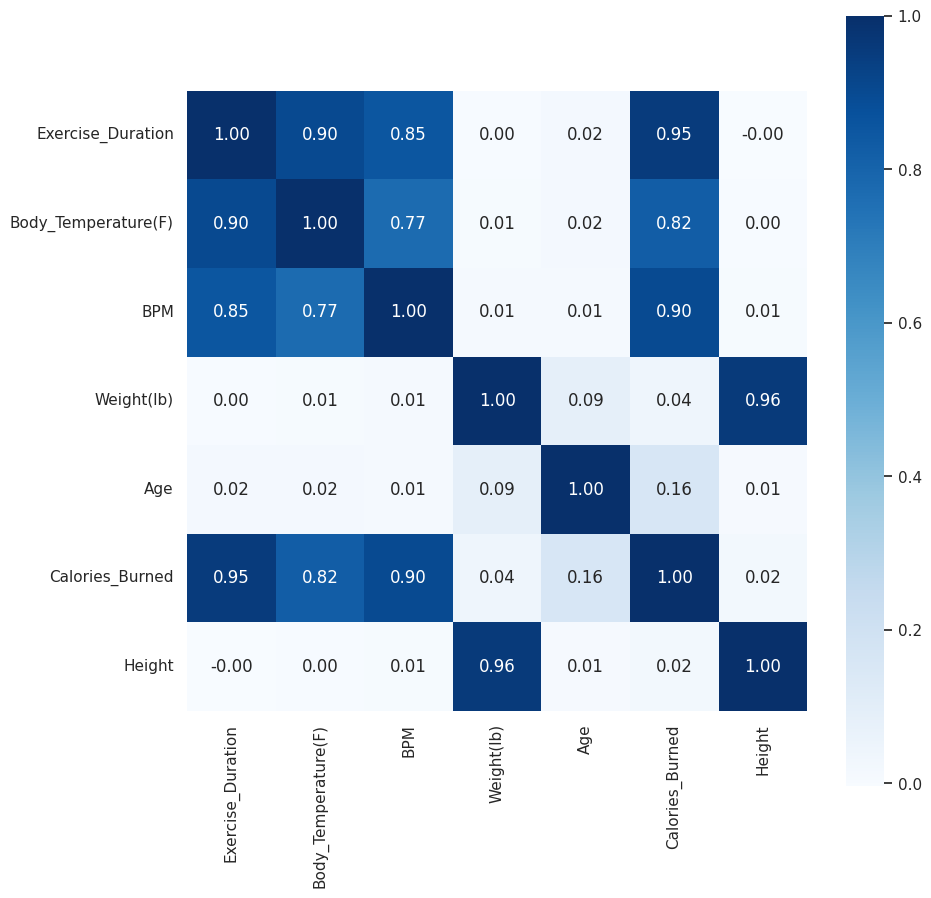

In [ ]:
# 히트맵으로 그려보기

plt.figure(figsize=(10,10))
sns.heatmap(corr_df, cbar=True, square=True, fmt='.2f', 
            annot=True, annot_kws={'size':12}, cmap="Blues")
# ax = sns.heatmap(corr_df, annot=True, annot_kws=dict(color='g'), cmap='RdBu')
# plt.show()


* 신장과 체중은 높은 양의 상관
* 운동기간, 체온, BPM과 소모된 칼로리 상관관계가 높다
    * 운동 시간이 더 많은 칼로리를 태울 것이고
    * 심박수가 더 높아질 것이다.

# 데이터 준비

### feature scaling

In [ ]:
# train_new.columns

In [ ]:
train_new["Log_Body_Temperature(F)"] = np.log1p(train_new["Body_Temperature(F)"]) 
# f, ax = plt.subplots(figsize = (10, 6)) 
# sns.distplot(train_new["Log_Body_Temperature(F)"]) 

In [ ]:
# X_test["Log_Body_Temperature(F)"] = np.log1p(X_test["Body_Temperature(F)"]) 
# f, ax = plt.subplots(figsize = (10, 6)) 
# sns.distplot(X_test["Log_Body_Temperature(F)"]) 

In [ ]:
train_new["Log_BPM"] = np.log1p(train_new["BPM"]) 
# f, ax = plt.subplots(figsize = (10, 6)) 
# sns.distplot(train_new["Log_BPM"]) 

In [ ]:
# X_test["Log_BPM"] = np.log1p(X_test["BPM"]) 
# f, ax = plt.subplots(figsize = (10, 6)) 
# sns.distplot(X_test["Log_BPM"]) 

In [ ]:
# 나이대 만드는 함수
def age_categorize(age):
    age = (age // 10) * 10
    return age

In [ ]:
train_new["cat_Age"] = train_new["Age"].apply(age_categorize)
# sns.distplot(train_new["cat_Age"]) 

In [ ]:
# X_test["cat_Age"] = X_test["Age"].apply(age_categorize)
# sns.distplot(X_test["cat_Age"]) 

## 인코딩

In [ ]:
# 바이너리 데이터 처리
train_new.replace({"Gender":{"M":0, "F":1}}, inplace = True)
X_test.replace({"Gender":{"M":0, "F":1}}, inplace = True)

In [ ]:
train_new.head()

,Exercise_Duration,Body_Temperature(F),BPM,Weight(lb),Weight_Status,Gender,Age,Calories_Burned,Height
ID,,,,,,,,,
TRAIN_0000,26.0,105.6,107.0,154.3,Normal Weight,1,45,166.0,69.0
TRAIN_0001,7.0,103.3,88.0,224.9,Overweight,0,50,33.0,78.0
TRAIN_0002,7.0,103.3,86.0,218.3,Overweight,0,29,23.0,75.0
TRAIN_0003,17.0,104.0,99.0,147.7,Normal Weight,1,33,91.0,66.0
TRAIN_0004,9.0,102.7,88.0,169.8,Normal Weight,0,38,32.0,70.0


In [ ]:
X_test.head()

,Exercise_Duration,Body_Temperature(F),BPM,Weight(lb),Weight_Status,Gender,Age,Height
ID,,,,,,,,
TEST_0000,26.0,105.1,107.0,114.6,Normal Weight,1,45,61.0
TEST_0001,29.0,104.9,111.0,198.4,Overweight,0,21,74.0
TEST_0002,11.0,104.0,90.0,169.8,Normal Weight,0,58,69.0
TEST_0003,24.0,105.4,108.0,196.2,Overweight,0,35,72.0
TEST_0004,29.0,106.0,116.0,147.7,Normal Weight,1,67,67.0


In [ ]:
X_test = X_test.drop(columns='Weight_Status')

## 데이터셋 분리

In [ ]:
train_new.columns

Index(['Exercise_Duration', 'Body_Temperature(F)', 'BPM', 'Weight(lb)',
       'Weight_Status', 'Gender', 'Age', 'Calories_Burned', 'Height',
       'Log_Body_Temperature(F)', 'Log_BPM', 'cat_Age'],
      dtype='object')

In [ ]:
label_name = 'Calories_Burned'

X = train_new.drop(columns=[label_name], axis=1)
y = train_new[label_name]

X.shape, y.shape

((7499, 11), (7499,))

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.1, random_state=42)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((6749, 11), (750, 11), (6749,), (750,))

# 머신러닝

### XGBoost Regressor

### 모델 학습

In [ ]:
# 모델 생성
model = XGBRegressor()

In [ ]:
# 모델 학습 X_train
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### 평가

In [ ]:
val_pred = model.predict(X_valid)

ValueError: ignored

In [ ]:
mse = metrics.mean_squared_error(y_valid, val_pred)

In [ ]:
print("MSE : ", mse)

MSE :  6.063075286073964


In [ ]:
from sklearn.metrics import mean_squared_error

def RMSE(y_test, y_predict):
   return np.sqrt(mean_squared_error(y_test, y_predict))

In [ ]:
print("RMSE :", RMSE(y_valid, val_pred))

RMSE : 2.4623312705795626


# LGBMRegressor

In [ ]:
# 모델생성
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(random_state=42)
lgbm

LGBMRegressor(random_state=42)

In [ ]:
# lgbm.fit(X_train, y_train)

In [ ]:
from sklearn.model_selection import cross_val_predict

y_val_pred_lgbm = cross_val_predict(lgbm, X, y, cv=5)

ValueError: ignored

In [ ]:
from sklearn.metrics import mean_squared_error

rmse_lgbm = mean_squared_error(y, y_val_pred_lgbm) ** 0.5

rmse_lgbm

2.9261860356422726

In [ ]:
lgbm.fit(X, y)

LGBMRegressor(random_state=42)

In [ ]:
y_pred_lgbm = lgbm.predict(X_test)
y_pred_lgbm = y_pred_lgbm ** 2

ValueError: ignored

In [ ]:
fi_lgbm = pd.Series(lgbm.feature_importances_)
fi_lgbm.index = lgbm.feature_name_

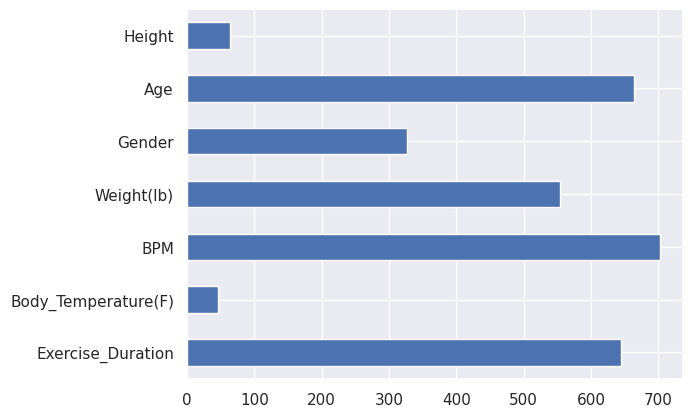

In [ ]:
fi_lgbm.plot.barh();

In [ ]:
sub["Calories_Burned"] = y_pred_lgbm

In [ ]:
file_name = f"submit_tf_{rmse_lgbm:.5f}.csv"
file_name

'submit_tf_2.44654.csv'

In [ ]:
sub.to_csv(file_name)
pd.read_csv(file_name).head(2)

,ID,Calories_Burned
0,TEST_0000,29855.590457
1,TEST_0001,36113.954319


In [ ]:
from google.colab import files

files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 딥러닝

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7500 entries, TEST_0000 to TEST_7499
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Exercise_Duration    7500 non-null   float64
 1   Body_Temperature(F)  7500 non-null   float64
 2   BPM                  7500 non-null   float64
 3   Weight(lb)           7500 non-null   float64
 4   Gender               7500 non-null   int64  
 5   Age                  7500 non-null   int64  
 6   Height               7500 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 468.8+ KB


In [ ]:
# tensorflow import 
import tensorflow as tf

In [ ]:
X_train.iloc[0].shape

(7,)

## 딥러닝 모델 만들기

In [ ]:
model_d = tf.keras.models.Sequential([
    # tf.keras.layers.BatchNormalization(input_shape=X_train.iloc[0].shape),
    # tf.keras.layers.Dense(units=64, activation='relu', input_shape=X_train.iloc[0].shape),
    tf.keras.layers.Dense(units=128, activation='relu', input_shape=X_train.iloc[0].shape),
    # tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    # tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1)
])

### 모델 컴파일

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_d.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])

In [ ]:
model_d.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,393
Trainable params: 11,393
Non-trainable params: 0
_________________________________________________________________


### 학습

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=150)

history = model_d.fit(X_train, y_train,
                      epochs=1000, verbose = 0, 
                      validation_data=(X_valid, y_valid), 
                      callbacks=[early_stop])

history

KeyboardInterrupt: ignored

In [ ]:
df_hist = pd.DataFrame(history.history)
df_hist.tail()

In [ ]:
# loss plot
df_hist[['loss', 'val_loss']].plot()

In [ ]:
# mse plot
df_hist[['mse', 'val_mse']].plot()

## 평가
* 평가 산식 : RMSE

In [ ]:
loss, mse = model_d.evaluate(X_valid, y_valid)
loss, mse

In [ ]:
# predict
y_valid_pred = model_d.predict(X_valid).flatten()
y_valid_pred[:5]

In [ ]:
# jointplot
sns.jointplot(x=y_valid, y=y_valid_pred, kind='reg')

### RMSE

In [ ]:
print("RMSE :", RMSE(y_valid, y_valid_pred))

In [ ]:
rmse = RMSE(y_valid, y_valid_pred)

## 예측

In [ ]:
# predict
y_predict = model.predict(X_test).flatten()
y_predict[:5]

## 제출

In [ ]:
sub.head()

In [ ]:
sub[label_name] = y_predict

In [ ]:
# file_name = f"submit_tf_{rmse:.5f}.csv"
# file_name

In [ ]:
# sub.to_csv(file_name)
# pd.read_csv(file_name).head(2)

In [ ]:
# from google.colab import files

# files.download(file_name)